Task:
1. Try to plot the Jet and MET pT response curve with increased statistics
 * each event should have multiple jets so 1000 events -> few thousand jets




In [1]:
import numpy as np
import pandas as pd
import time
import tqdm

import ROOT

import vector

Welcome to JupyROOT 6.30/02


In [2]:
import torch
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device = "cuda"

In [4]:
# Datasets
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

# Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [5]:
len(ds_train)

800800

In [6]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [7]:
# JP 2024-02-29: currently torch int8 onnx export does not work with MultiheadAttention because of the following:
# - it uses q_scaling_product.mul_scalar which is not supported in ONNX opset 17: the fix is to just remove the q_scaling_product
# - somehow, the "need_weights" option confuses the ONNX exporter because the multiheaded attention layer then returns a tuple: the fix is to make the MHA always return just the attended values only
# I lifted these two modules directly from the pytorch code and made the modifications here.

import torch
from torch import nn
import torch.nn.functional as nnF

from torch import Tensor
from typing import Optional, Tuple

class QuantizeableMultiheadAttention(nn.MultiheadAttention):
    _FLOAT_MODULE = nn.MultiheadAttention

    r"""Quantizable implementation of the MultiheadAttention.

    Note::
        Please, refer to :class:`~torch.nn.MultiheadAttention` for more
        information

    Allows the model to jointly attend to information from different
    representation subspaces.
    See reference: Attention Is All You Need

    The original MHA module is not quantizable.
    This reimplements it by explicitly instantiating the linear layers.

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Note that if :attr:`kdim` and :attr:`vdim` are None, they will be set
    to :attr:`embed_dim` such that query, key, and value have the same
    number of features.

    Examples::

        >>> import torch.ao.nn.quantizable as nnqa
        >>> multihead_attn = nnqa.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    Note::
        Please, follow the quantization flow to convert the quantizable MHA.
    """
    __constants__ = ['batch_first']

    def __init__(self, embed_dim: int, num_heads: int,
                 dropout: float = 0., bias: bool = True,
                 add_bias_kv: bool = False, add_zero_attn: bool = False,
                 kdim: Optional[int] = None, vdim: Optional[int] = None, batch_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(embed_dim, num_heads, dropout,
                         bias, add_bias_kv,
                         add_zero_attn, kdim, vdim, batch_first,
                         **factory_kwargs)
        self.linear_Q = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_K = nn.Linear(self.kdim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_V = nn.Linear(self.vdim, self.embed_dim, bias=bias, **factory_kwargs)
        # for the type: ignore, see https://github.com/pytorch/pytorch/issues/58969
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)  # type: ignore[assignment]

        # Functionals
        # self.q_scaling_product = torch.ao.nn.quantized.FloatFunctional()
        # note: importing torch.ao.nn.quantized at top creates a circular import

        # Quant/Dequant
        self.quant_attn_output = torch.ao.quantization.QuantStub()
        self.quant_attn_output_weights = torch.ao.quantization.QuantStub()
        self.dequant_q = torch.ao.quantization.DeQuantStub()
        self.dequant_k = torch.ao.quantization.DeQuantStub()
        self.dequant_v = torch.ao.quantization.DeQuantStub()

    def _get_name(self):
        return 'QuantizableMultiheadAttention'

    @classmethod
    def from_float(cls, other):
        assert type(other) == cls._FLOAT_MODULE
        assert hasattr(other, 'qconfig'), "The float module must have 'qconfig'"
        # Setting the dropout to 0.0!
        observed = cls(other.embed_dim, other.num_heads, other.dropout,
                       (other.in_proj_bias is not None),
                       (other.bias_k is not None),
                       other.add_zero_attn, other.kdim, other.vdim,
                       other.batch_first)
        observed.bias_k = other.bias_k
        observed.bias_v = other.bias_v
        observed.qconfig = other.qconfig

        # Set the linear weights
        # for the type: ignores, see https://github.com/pytorch/pytorch/issues/58969
        observed.out_proj.weight = other.out_proj.weight  # type: ignore[has-type]
        observed.out_proj.bias = other.out_proj.bias  # type: ignore[has-type]
        if other._qkv_same_embed_dim:
            # Use separate params
            bias = other.in_proj_bias
            _start = 0
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_Q.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_Q.bias = bias

            bias = other.in_proj_bias
            _start = _end
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_K.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_K.bias = bias

            bias = other.in_proj_bias
            _start = _end
            weight = other.in_proj_weight[_start:, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:], bias.requires_grad)
            observed.linear_V.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_V.bias = bias
        else:
            observed.linear_Q.weight = nn.Parameter(other.q_proj_weight)
            observed.linear_K.weight = nn.Parameter(other.k_proj_weight)
            observed.linear_V.weight = nn.Parameter(other.v_proj_weight)
            if other.in_proj_bias is None:
                observed.linear_Q.bias = None  # type: ignore[assignment]
                observed.linear_K.bias = None  # type: ignore[assignment]
                observed.linear_V.bias = None  # type: ignore[assignment]
            else:
                observed.linear_Q.bias = nn.Parameter(other.in_proj_bias[0:other.embed_dim])
                observed.linear_K.bias = nn.Parameter(other.in_proj_bias[other.embed_dim:(other.embed_dim * 2)])
                observed.linear_V.bias = nn.Parameter(other.in_proj_bias[(other.embed_dim * 2):])
        observed.eval()
        # Explicit prepare
        observed = torch.ao.quantization.prepare(observed, inplace=True)
        return observed

    @torch.jit.unused
    def dequantize(self):
        r"""Utility to convert the quantized MHA back to float.

        The motivation for this is that it is not trivial to conver the weights
        from the format that is used in the quantized version back to the
        float.
        """
        fp = self._FLOAT_MODULE(self.embed_dim, self.num_heads, self.dropout,
                                (self.linear_Q._weight_bias()[1] is not None),
                                (self.bias_k is not None),
                                self.add_zero_attn, self.kdim, self.vdim, self.batch_first)
        assert fp._qkv_same_embed_dim == self._qkv_same_embed_dim
        if self.bias_k is not None:
            fp.bias_k = nn.Parameter(self.bias_k.dequantize())
        if self.bias_v is not None:
            fp.bias_v = nn.Parameter(self.bias_v.dequantize())

        # Set the linear weights
        # Note: Because the linear layers are quantized, mypy does not nkow how
        # to deal with them -- might need to ignore the typing checks.
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        w, b = self.out_proj._weight_bias()  # type: ignore[operator, has-type]
        fp.out_proj.weight = nn.Parameter(w.dequantize())
        if b is not None:
            fp.out_proj.bias = nn.Parameter(b)

        wQ, bQ = self.linear_Q._weight_bias()  # type: ignore[operator]
        wQ = wQ.dequantize()
        wK, bK = self.linear_K._weight_bias()  # type: ignore[operator]
        wK = wK.dequantize()
        wV, bV = self.linear_V._weight_bias()  # type: ignore[operator]
        wV = wV.dequantize()
        if fp._qkv_same_embed_dim:
            # Use separate params
            _start = 0
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wQ
            if fp.in_proj_bias is not None:
                assert all(bQ == 0)
                fp.in_proj_bias[_start:_end] = bQ

            _start = _end
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wK
            if fp.in_proj_bias is not None:
                assert all(bK == 0)
                fp.in_proj_bias[_start:_end] = bK

            _start = _end
            fp.in_proj_weight[_start:, :] = wV
            if fp.in_proj_bias is not None:
                assert all(bV == 0)
                fp.in_proj_bias[_start:] = bV
        else:
            fp.q_proj_weight = nn.Parameter(wQ)
            fp.k_proj_weight = nn.Parameter(wK)
            fp.v_proj_weight = nn.Parameter(wV)
            if fp.in_proj_bias is None:
                self.linear_Q.bias = None
                self.linear_K.bias = None
                self.linear_V.bias = None
            else:
                fp.in_proj_bias[0:fp.embed_dim] = bQ
                fp.in_proj_bias[fp.embed_dim:(fp.embed_dim * 2)] = bK
                fp.in_proj_bias[(fp.embed_dim * 2):] = bV

        return fp


    @classmethod
    def from_observed(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does float -> observed only
        # See nn.quantized.MultiheadAttention
        raise NotImplementedError("It looks like you are trying to prepare an "
                                  "MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor,
                key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True,
                attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True,
                is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Note::
        Please, refer to :func:`~torch.nn.MultiheadAttention.forward` for more
        information

    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - is_causal: If specified, applies a causal mask as attention mask. Mutually exclusive with providing attn_mask.
          Default: ``False``.
        - average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
          heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
          effect when ``need_weights=True.``. Default: True (i.e. average weights across heads)

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - attn_output_weights: If ``average_attn_weights=True``, returns attention weights averaged
          across heads of shape :math:`(N, L, S)`, where N is the batch size, L is the target sequence length,
          S is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(N, num_heads, L, S)`.
        """
        return self._forward_impl(query, key, value, key_padding_mask,
                                  need_weights, attn_mask, average_attn_weights,
                                  is_causal)

    def _forward_impl(self,
                      query: Tensor,
                      key: Tensor,
                      value: Tensor,
                      key_padding_mask: Optional[Tensor] = None,
                      need_weights: bool = True,
                      attn_mask: Optional[Tensor] = None,
                      average_attn_weights: bool = True,
                      is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        # This version will not deal with the static key/value pairs.
        # Keeping it here for future changes.
        #
        # TODO: This method has some duplicate lines with the
        # `torch.nn.functional.multi_head_attention`. Will need to refactor.
        static_k = None
        static_v = None

        if attn_mask is not None and is_causal:
            raise AssertionError("Only allow causal mask or attn_mask")

        if is_causal:
            raise AssertionError("causal mask not supported by AO MHA module")

        if self.batch_first:
            query, key, value = (x.transpose(0, 1) for x in (query, key, value))

        tgt_len, bsz, embed_dim_to_check = query.size()
        assert self.embed_dim == embed_dim_to_check
        # allow MHA to have different sizes for the feature dimension
        assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

        head_dim = self.embed_dim // self.num_heads
        assert head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        scaling = float(head_dim) ** -0.5

        q = self.linear_Q(query)
        k = self.linear_K(key)
        v = self.linear_V(value)

        #JP fix here: disabled this
        # q = self.q_scaling_product.mul_scalar(q, scaling)

        if attn_mask is not None:
            if attn_mask.dtype == torch.uint8:
                warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
                attn_mask = attn_mask.to(torch.bool)
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f'Only float and bool types are supported for attn_mask, not {attn_mask.dtype}'

            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0)
                if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 2D attn_mask is not correct.')
            elif attn_mask.dim() == 3:
                if list(attn_mask.size()) != [bsz * self.num_heads, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 3D attn_mask is not correct.')
            else:
                raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
            # attn_mask's dim is 3 now.

        # convert ByteTensor key_padding_mask to bool
        if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            key_padding_mask = key_padding_mask.to(torch.bool)
        if self.bias_k is not None and self.bias_v is not None:
            if static_k is None and static_v is None:

                # Explicitly assert that bias_k and bias_v are not None
                # in a way that TorchScript can understand.
                bias_k = self.bias_k
                assert bias_k is not None
                bias_v = self.bias_v
                assert bias_v is not None

                k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
                v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
                if attn_mask is not None:
                    attn_mask = nnF.pad(attn_mask, (0, 1))
                if key_padding_mask is not None:
                    key_padding_mask = nnF.pad(key_padding_mask, (0, 1))
            else:
                assert static_k is None, "bias cannot be added to static key."
                assert static_v is None, "bias cannot be added to static value."
        else:
            assert self.bias_k is None
            assert self.bias_v is None

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, head_dim).transpose(0, 1)
        if k is not None:
            k = k.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)
        if v is not None:
            v = v.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)

        if static_k is not None:
            assert static_k.size(0) == bsz * self.num_heads
            assert static_k.size(2) == head_dim
            k = static_k

        if static_v is not None:
            assert static_v.size(0) == bsz * self.num_heads
            assert static_v.size(2) == head_dim
            v = static_v

        src_len = k.size(1)

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        if self.add_zero_attn:
            src_len += 1
            k_zeros = torch.zeros((k.size(0), 1) + k.size()[2:])
            if k.is_quantized:
                k_zeros = torch.quantize_per_tensor(k_zeros, k.q_scale(), k.q_zero_point(), k.dtype)
            k = torch.cat([k, k_zeros], dim=1)
            v_zeros = torch.zeros((v.size(0), 1) + k.size()[2:])
            if v.is_quantized:
                v_zeros = torch.quantize_per_tensor(v_zeros, v.q_scale(), v.q_zero_point(), v.dtype)
            v = torch.cat([v, v_zeros], dim=1)

            if attn_mask is not None:
                attn_mask = nnF.pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = nnF.pad(key_padding_mask, (0, 1))

        # Leaving the quantized zone here
        q = self.dequant_q(q)
        k = self.dequant_k(k)
        v = self.dequant_v(v)
        attn_output_weights = torch.bmm(q, k.transpose(1, 2))
        assert list(attn_output_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_output_weights.masked_fill_(attn_mask, float('-inf'))
            else:
                attn_output_weights += attn_mask

        if key_padding_mask is not None:
            attn_output_weights = attn_output_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_output_weights = attn_output_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf'),
            )
            attn_output_weights = attn_output_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_output_weights = nnF.softmax(
            attn_output_weights, dim=-1)
        attn_output_weights = nnF.dropout(attn_output_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_output_weights, v)
        assert list(attn_output.size()) == [bsz * self.num_heads, tgt_len, head_dim]
        if self.batch_first:
            attn_output = attn_output.view(bsz, tgt_len, self.embed_dim)
        else:
            attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, self.embed_dim)

        # Reentering the quantized zone
        attn_output = self.quant_attn_output(attn_output)
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        attn_output = self.out_proj(attn_output)  # type: ignore[has-type]

        #JP fix: removed need_weights part from here, return attn_output instead of tuple
        return attn_output

class QuantizedMultiheadAttention(QuantizeableMultiheadAttention):
    _FLOAT_MODULE = torch.ao.nn.quantizable.MultiheadAttention

    def _get_name(self):
        return "QuantizedMultiheadAttention"

    @classmethod
    def from_float(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does observed -> quantized only
        raise NotImplementedError("It looks like you are trying to convert a "
                                  "non-observed MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    @classmethod
    def from_observed(cls, other):
        converted = torch.ao.quantization.convert(other, mapping=None,
                                                  inplace=False,
                                                  remove_qconfig=True,
                                                  convert_custom_config_dict=None)
        converted.__class__ = cls
        # Remove the parameters for the bias_k and bias_v to quantize them
        # TODO: This is a potential source of accuracy drop.
        #       quantized cat takes the scale and zp of the first
        #       element, which might lose the precision in the bias_k
        #       and the bias_v (which are cat'ed with k/v being first).
        if converted.bias_k is not None:
            bias_k = converted._parameters.pop('bias_k')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,
                                                      reduce_range=False)
            bias_k = torch.quantize_per_tensor(bias_k, sc, zp, torch.quint8)
            setattr(converted, 'bias_k', bias_k)  # noqa: B010

        if converted.bias_v is not None:
            bias_v = converted._parameters.pop('bias_v')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,  # type: ignore[possibly-undefined]
                                                      reduce_range=False)
            bias_v = torch.quantize_per_tensor(bias_v, sc, zp, torch.quint8)
            setattr(converted, 'bias_v', bias_v)  # noqa: B010

        del converted.in_proj_weight
        del converted.in_proj_bias

        return converted


In [8]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss
        
def mlpf_loss(y, ypred, mask):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    nelem = torch.sum(mask)
    npart = torch.sum(y["cls_id"] != 0)
    
    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all elements that were not padded
    loss["Classification"] = loss_classification.sum() / npart
    
    mom_normalizer = y["momentum"][y["cls_id"] != 0].std(axis=0)
    reg_losses = loss_regression[y["cls_id"] != 0]
    # average over all true particles
    loss["Regression"] = (reg_losses / mom_normalizer).sum() / npart

    px = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 3:4] * msk_true_particle
    py = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 2:3] * msk_true_particle
    pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

    px = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle
    py = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle
    true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)
    loss["MET"] = torch.nn.functional.huber_loss(pred_met, true_met).mean()

    loss["Total"] = loss["Classification"] + loss["Regression"]
    # loss["Total"] += 0.1*loss["MET"]
    return loss

In [9]:
class QuantizeFeaturesStub(torch.ao.quantization.QuantStub):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act()
        )
        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        # x = self.mul.mul(x, mask.unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum

In [11]:
# Define parameters
max_events_train = 10000
max_events_eval = 10000
events_per_batch = 1000
nepochs = 1
batch_size = 50  # Reduce batch size

# Define your model and optimizer
# model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device=device)
# optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

# Define a function to stream data from the dataset
def stream_data(dataset, batch_size):
    current_index = 0
    while current_index < len(dataset):
        batch = []
        for _ in range(batch_size):
            if current_index >= len(dataset):
                break
            batch.append(dataset[current_index])
            current_index += 1
        yield batch


# Training 
loss_vals_epochs = []
best_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
no_improvement = 0

for epoch in range(nepochs):
    loss_vals_steps = []
    
    # Generate indices for batches
    inds_train = range(0, max_events_train, events_per_batch * 10)
    
    # Create tqdm instance to show progress
    data_stream = stream_data(ds_train, batch_size)
    data_stream = tqdm.tqdm(data_stream, total=len(inds_train))
    
    for batch in data_stream:
#         optimizer.zero_grad()

        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch]
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch]

        X_features_padded = pad_sequence(X_features, batch_first=True).to(device=device)
        y_targets_padded = pad_sequence(y_targets, batch_first=True).to(device=device)
        mask = X_features_padded[:, :, 0] != 0

        preds = model(X_features_padded, mask)
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)

        loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)
        loss["Total"].backward()
        optimizer.step()
        
        loss_vals_steps.append(loss["Total"].detach().cpu().item())

        # Update tqdm progress bar
        data_stream.set_description(f"Epoch {epoch}, Loss: {loss_vals_steps[-1]:.2f}")

    epoch_loss = np.mean(loss_vals_steps)
    loss_vals_epochs.append(epoch_loss)
    print(f"Epoch {epoch}, loss={epoch_loss:.2f}")

    # Check for improvement in validation loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement = 0
    else:
        no_improvement += 1

    # If no improvement for 'patience' epochs, stop training
    if no_improvement >= patience:
        print("Early stopping: No improvement for", patience, "epochs")
        break


Epoch 0, Loss: 0.32: : 80080it [1:27:12, 15.30it/s]                             


Epoch 0, loss=0.36


<function __main__.unpack_predictions(preds)>

In [12]:
#  print(ind+events_per_batch)
# print(ind)
# print(batch_inds)
print(f'X_features',len(X_features))
print(f'y_features',len(y_targets))

X_features 10
y_features 10


In [13]:
#put the model back on CPU
model = model.to(device="cpu")

all_preds = []
all_targets = []

ds_elems = [ds_train[i] for i in range(max_events_train, max_events_train + max_events_eval)]

# Define batch size
batch_size = 32  
for i in range(0, len(ds_elems), batch_size):
    batch_elems = ds_elems[i:i + batch_size]
    # input features
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    #  target labels
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    #  mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    #  model prediction, loss computation
    preds = model(X_features_padded, mask)
    preds = preds[0].detach(), preds[1].detach()
    # Update mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    # Unpack predictions and targets for the batch
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    # append to a list 
    all_preds.append(preds_unpacked)
    all_targets.append(targets_unpacked)
    # Compute loss for the batch
    loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

In [24]:
preds_unpacked

NameError: name 'preds_unpacked' is not defined

In [14]:
msk_true_particles = targets_unpacked["cls_id"]!=0
msk_pred_particles = preds_unpacked["cls_id"]!=0


pt_target = targets_unpacked["pt"][msk_true_particles].numpy()
pt_pred = preds_unpacked["pt"][msk_true_particles].numpy()

eta_target = targets_unpacked["eta"][msk_true_particles].numpy()
eta_pred = preds_unpacked["eta"][msk_true_particles].numpy()

sphi_target = targets_unpacked["sin_phi"][msk_true_particles].numpy()
sphi_pred = preds_unpacked["sin_phi"][msk_true_particles].numpy()

cphi_target = targets_unpacked["cos_phi"][msk_true_particles].numpy()
cphi_pred = preds_unpacked["cos_phi"][msk_true_particles].numpy()

energy_target = targets_unpacked["energy"][msk_true_particles].numpy()
energy_pred = preds_unpacked["energy"][msk_true_particles].numpy()

px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_true_particles
py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_true_particles
pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

In [15]:
len(targets_unpacked)
targets_unpacked

{'cls_id': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1,
          1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          3, 0, 0, 2, 2, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
          3, 3, 3, 0, 2, 3, 2, 2, 2, 2, 0, 0, 3, 0, 3, 3, 3, 3, 3, 2, 3, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0],
         [1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 2, 3, 0,
          3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3

In [16]:
len(preds_unpacked)

10

In [17]:
px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
# phi = np.arctan2(targets_unpacked["sin_phi"], targets_unpacked["cos_phi"]) * msk_true_particles

px_np = px.detach().cpu().numpy()
py_np = py.detach().cpu().numpy()
pz_np = pz.detach().cpu().numpy()
# phi_np = phi.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

true_mom = np.sqrt(np.sum(px_np, axis=1)**2 + np.sum(py_np, axis=1)**2 + np.sum(pz_np, axis=1)**2)

E = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


In [18]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E.shape)
print("px Shape", px.shape)
print("py Shape", py.shape)
print("pz Shape", pz.shape)

E Shape (4, 171)
px Shape torch.Size([4, 171])
py Shape torch.Size([4, 171])
pz Shape torch.Size([4, 171])


In [19]:
import fastjet as fj
import numpy as np
import awkward

# Four momentum 
px_np = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py_np = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz_np = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
E_np = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


particles = []
for ip in range(E.shape[0]):
    for ix in range(E.shape[1]):
        px_value = float(px[ip, ix])
        py_value = float(py[ip, ix])
        pz_value = float(pz[ip, ix])
        E_value = float(E[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        particles.append(particle)

# print(particles)

In [20]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    jet_ptcut = 20
    
    cluster = fj.ClusterSequence(particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

gen_jets = []
for future in futures:
    gen_jets.extend(future.result())


#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [21]:
for i, jet in enumerate(gen_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.04207113714907656 -2.294446773446033 3.8637198096925522 0.21077144145965576
Jet 3 : 0.05501835700795849 1.7015463977073388 2.9580240122352164 0.15583454072475433
Jet 4 : 0.06359913036312283 -1.2333173096636556 4.73913413874164 0.1184191107749939
Jet 5 : 0.08707761535144456 -0.7762948729314197 3.513933736499252 0.11465997993946075
Jet 6 : 0.16184824428645617 2.105999764182302 4.020031974279469 0.6746672987937927
Jet 7 : 0.31891328440639516 -0.11105964370541344 3.513577082753678 0.3253082036972046
Jet 8 : 0.21458386583894404 1.4332742869180173 4.1522520120423305 0.4754031002521515
Jet 9 : 0.2217507032288144 -1.7443558813760374 2.985267149371785 0.6538288593292236
Jet 10 : 0.2321124434233074 -0.9203590660341586 1.598646164573508 0.3375573456287384
Jet 11 : 0.24835511081562286 0.7036822729619935 1.9210313695238448 0.3124234676361084
Jet 12 : 0.2577485722077771 -1.163860106491377 5.2386921087772995 0.45293498039245605
Jet 13 : 0.2781750949943036 1.1923

In [22]:
print("Number of Jets:", len(gen_jets))


gen_jet_pt = [jet.pt() for jet in gen_jets]

Number of Jets: 107


In [23]:
import ROOT
import numpy as np

bins = [10, 20, 30, 40, 60, 80, 100, 200]

x_vals = []
ratio_iqr_median = []

# Iterating over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filtering out jet pT values within each bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]
    print("Jet pT values in bin {}: {}".format(i+1, jet_values_in_bin))  # Debugging

Jet pT values in bin 1: [18.788187735636516, 18.780285676203, 19.744924007813818, 19.745749378053734, 19.839232890687864, 12.368439791326269, 14.09038555423043, 16.18462738188143, 16.058404518472518]
Jet pT values in bin 2: [28.537747711204815, 27.92339907518513]
Jet pT values in bin 3: [33.03304301836021, 31.45727196319845, 32.819254166143814]
Jet pT values in bin 4: [45.01124918238766, 53.37940105293927, 42.83204449113894, 51.661615323385796, 40.18225223164555, 46.788335784418834, 48.822975916059356, 51.22031082148975]
Jet pT values in bin 5: [76.76856715752227]
Jet pT values in bin 6: [85.92697527385364]
Jet pT values in bin 7: [101.83066676815662]


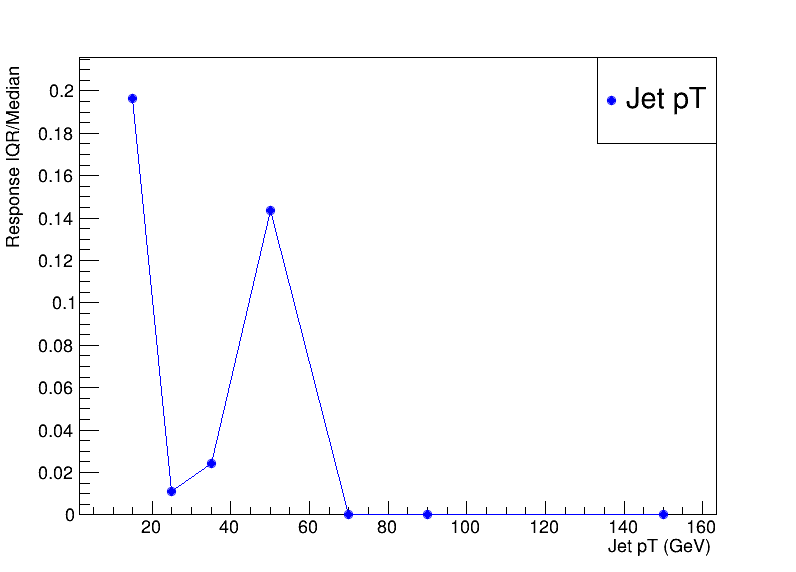

In [24]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter jet pT values within the bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any jet pT values in the bin
    if len(jet_values_in_bin) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue  # Skip calculation for this bin

    #  IQR and median for the jet pT values
    jet_iqr = np.percentile(jet_values_in_bin, 75) - np.percentile(jet_values_in_bin, 25)
    jet_median = np.median(jet_values_in_bin)
    ratio_iqr_median_ratio = jet_iqr / jet_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

#  We need to filter out NaN values,ROOT unable to print it
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))
# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet pT (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Jet pT", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


In [25]:
ratio_iqr_median

[0.19629730627647413,
 0.010880909634087955,
 0.02400680782056452,
 0.14358528955008465,
 0.0,
 0.0,
 0.0]

In [26]:
# For reconstructed particles


In [27]:
reco_px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_pred_particles
reco_py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_pred_particles
reco_pz = preds_unpacked["pt"] * np.sinh(preds_unpacked["eta"]) * msk_pred_particles
reco_phi = np.arctan2(preds_unpacked["sin_phi"], preds_unpacked["cos_phi"]) * msk_pred_particles

reco_px_np = reco_px.detach().cpu().numpy()
reco_py_np = reco_py.detach().cpu().numpy()
reco_pz_np = reco_pz.detach().cpu().numpy()
reco_phi_np = reco_phi.detach().cpu().numpy()

# print("reco_px_np", reco_px_np)
# print("reco_py_np", reco_py_np)
# print("reco_pz_np", reco_pz_np)
# print("reco_phi_np", reco_phi_np)

reco_pred_mom = np.sqrt(np.sum(reco_px_np, axis=1)**2 + np.sum(reco_py_np, axis=1)**2 + np.sum(reco_pz_np, axis=1)**2)

reco_E_np = np.sqrt(reco_px_np**2 + reco_py_np**2 + reco_pz_np**2)


In [28]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E_np.shape)
print("px Shape", reco_px_np.shape)
print("py Shape", reco_py_np.shape)
print("pz Shape", reco_pz_np.shape)


E Shape torch.Size([4, 171])
px Shape (4, 171)
py Shape (4, 171)
pz Shape (4, 171)


In [29]:

reco_particles = []   # TODO:Change this to reco_jets
for ip in range(E_np.shape[0]):
    for ix in range(E_np.shape[1]):
        px_value = float(reco_px_np[ip, ix])
        py_value = float(reco_py_np[ip, ix])
        pz_value = float(reco_pz_np[ip, ix])
        E_value = float(E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        reco_particles.append(particle)


In [30]:
# reco_particles

In [31]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

# Function to perform jet clustering
def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(reco_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

# Spliting particles list into chunks to process in parallel
chunks = [particles[i::num_threads] for i in range(num_threads)]

# jet clustering in parallel
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

reco_jets = []
for future in futures:
    reco_jets.extend(future.result())


In [32]:
for i, jet in enumerate(reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.0950697083959137 0.3628628347542296 2.9998606131379293 0.0
Jet 3 : 0.10285790940421541 -1.2253477644889066 4.659921053400183 0.1184191107749939
Jet 4 : 0.10850048722920232 -1.7060135924649558 2.968018956793744 0.6538288593292236
Jet 5 : 0.16564941071427414 -0.02048923845243078 2.7183313278200614 0.16451849043369293
Jet 6 : 0.17374009172510282 0.045118893388370426 2.3754815765812816 0.0
Jet 7 : 0.2096423854829563 0.048009243700695425 5.601971087643939 0.0
Jet 8 : 0.21192121915126003 0.9788329916149997 0.2262165387184454 76.81983505934477
Jet 9 : 0.24111857686791913 1.4425063528149098 4.154812435301968 0.4754031002521515
Jet 10 : 0.2941525094939013 -2.5831827399116403 3.367723864574657 1.767085075378418
Jet 11 : 0.31061133690114884 0.4266132803348739 5.192565008105359 0.3291206657886505
Jet 12 : 0.31391794486045227 -2.6036389911371534 5.9459254631223395 1.9794785976409912
Jet 13 : 0.36429328967724917 -1.006166464796966 2.5356097425256023 0.964855909

In [33]:
print("Number of Jets:", len(reco_jets))


reco_jet_pt = [jet.pt() for jet in reco_jets]

Number of Jets: 136


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


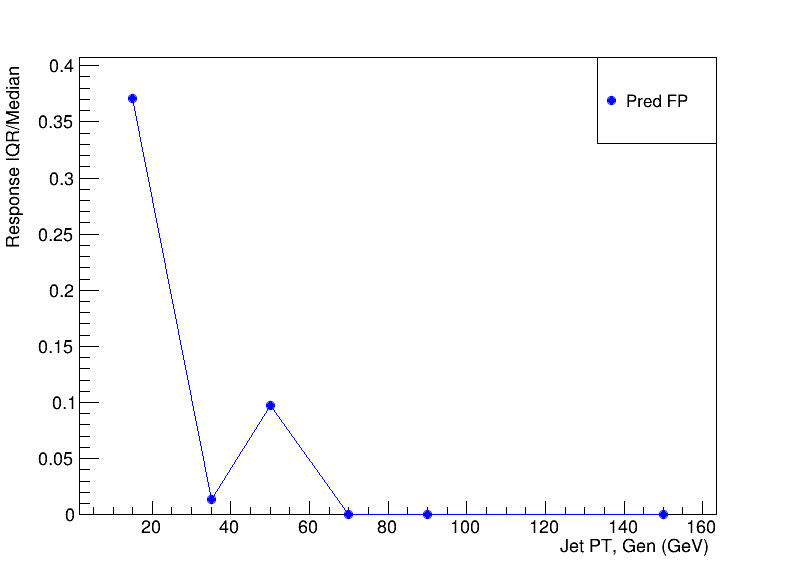

In [35]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter gen_jet pT values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Filter reco_jet pT values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any values in both gen_jet_pt and reco_jet_pt
    if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet PT, Gen (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Get the X and Y axes
xaxis = gr_ratio.GetXaxis()
yaxis = gr_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)


# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Pred FP", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


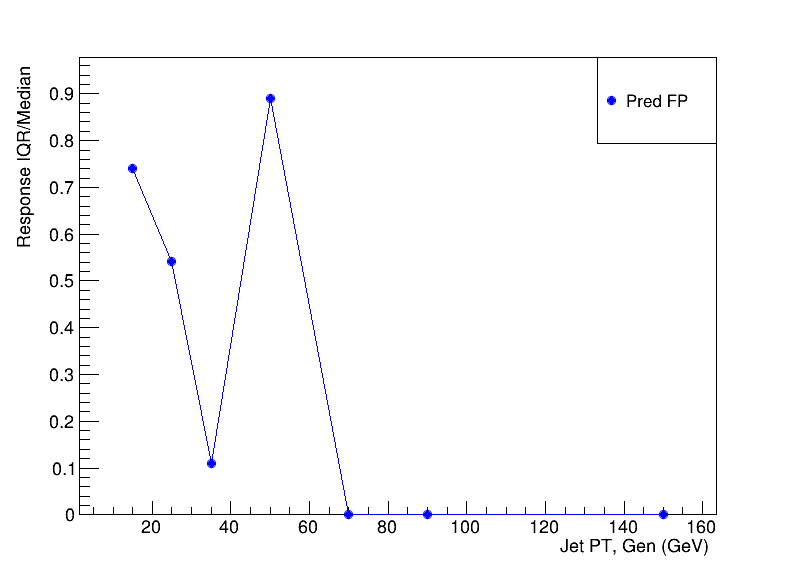

In [38]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Apply selection to gen_jet indices within the bin
    selected_indices = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices]

    # Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt
    if len(selected_indices) == 0 or len(matched_reco_jet_values) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen_jet_pt[idx] for reco, idx in zip(matched_reco_jet_values, selected_indices)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)


# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet PT, Gen (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")


# Get the X and Y axes
xaxis = gr_ratio.GetXaxis()
yaxis = gr_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Pred FP", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


In [41]:
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]

    # Apply selection to gen_jet indices within the bin
    selected_indices_gen_jet = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices_gen_jet]

    # Calculate the number of events in the bin
    num_events_gen_jet = len(selected_indices_gen_jet)
    num_events_reco_jet = len(matched_reco_jet_values)

    print(f"Bin {i+1}: Number of events (Gen Jet): {num_events_gen_jet}, Number of events (Reco Jet): {num_events_reco_jet}")


Bin 1: Number of events (Gen Jet): 9, Number of events (Reco Jet): 9
Bin 2: Number of events (Gen Jet): 2, Number of events (Reco Jet): 2
Bin 3: Number of events (Gen Jet): 3, Number of events (Reco Jet): 3
Bin 4: Number of events (Gen Jet): 8, Number of events (Reco Jet): 8
Bin 5: Number of events (Gen Jet): 1, Number of events (Reco Jet): 1
Bin 6: Number of events (Gen Jet): 1, Number of events (Reco Jet): 1
Bin 7: Number of events (Gen Jet): 1, Number of events (Reco Jet): 1


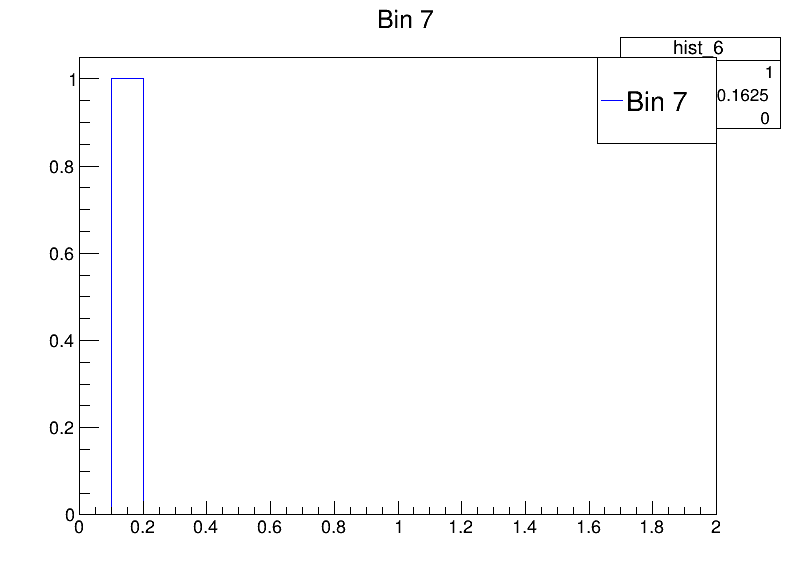

In [42]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Iterate over bins
for bin_index in range(len(bins) - 1):
    lim_low = bins[bin_index]
    lim_hi = bins[bin_index + 1]

    # Apply selection to gen_jet indices within the bin
    selected_indices_gen_jet = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices_gen_jet]

    # Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt
    if len(selected_indices_gen_jet) == 0 or len(matched_reco_jet_values) == 0:
        print(f"No events in Bin {bin_index + 1}.")
        continue

    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(matched_reco_jet_values, selected_indices_gen_jet)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median

    # Create a canvas for the bin
    canvas = ROOT.TCanvas(f"canvas_{bin_index}", f"Response Distribution in Bin {bin_index + 1}", 800, 600)

    # Create histogram for the response distribution in the bin
    hist = ROOT.TH1F(f"hist_{bin_index}", f"  Bin {bin_index + 1}", 20, 0, 2)  # Adjust binning as needed
    for val in ratio_values_in_bin:
        hist.Fill(val)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlue)
    hist.Draw()

    # Add legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist, f"Bin {bin_index + 1}", "l")
    legend.Draw()

    # Show the canvas
    canvas.Draw()


# Quantization INT8

In [43]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('onednn')
custom_module_config = {
        "float_to_observed_custom_module_class": {torch.nn.MultiheadAttention: QuantizeableMultiheadAttention},
        "observed_to_quantized_custom_module_class": {QuantizeableMultiheadAttention: QuantizedMultiheadAttention},
}

model_prepared = torch.ao.quantization.prepare(model, prepare_custom_config_dict=custom_module_config)

#calibrate on data
num_events_to_calibrate = 100
for ind in range(max_events_train,max_events_train+num_events_to_calibrate):
    _X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    _mask = _X[:, :, 0]!=0
    model_prepared(_X, _mask)

model_int8 = torch.ao.quantization.convert(model_prepared,convert_custom_config_dict=custom_module_config,)

/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [42]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0078]), zero_point=tensor([0]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0396]), zero_point=tensor([138]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0342]), zero_point=tensor([129]), dtype=torch.quint8)
    (3): Quantize(scale=tensor([0.0078]), zero_point=tensor([127]), dtype=torch.quint8)
    (4): Quantize(scale=tensor([0.0078]), zero_point=tensor([128]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0339]), zero_point=tensor([117]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([49.7997]), zero_point=tensor([62]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([22.5108]), zero_point=tensor([128]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([30.9407]), zero_point=tensor([130]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0122]), zero_point=tensor([0]), dtype=torch.quint8)
    (10): Quantize(scale=tensor([3.2249]), zero_point=tensor([0]), dtype=tor

In [43]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
preds = model_int8(X_features_padded, mask_quantized)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked_int8 = unpack_predictions(preds)

In [44]:
loss_int8 = mlpf_loss(targets_unpacked, preds_unpacked_int8, mask)

Text(0, 0.5, 'Final total loss')

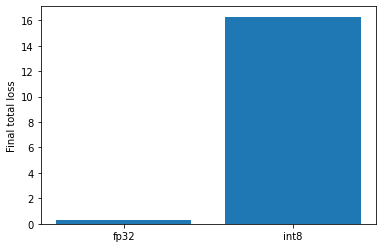

In [45]:
plt.bar(range(2), [loss["Total"].detach().numpy(), loss_int8["Total"].detach().numpy()])
plt.xticks(range(2), ["fp32", "int8"])
plt.ylabel("Final total loss")

In [46]:
pt_pred_int8 = preds_unpacked_int8["pt"][msk_true_particles].numpy()
eta_pred_int8 = preds_unpacked_int8["eta"][msk_true_particles].numpy()
sphi_pred_int8 = preds_unpacked_int8["sin_phi"][msk_true_particles].numpy()
cphi_pred_int8 = preds_unpacked_int8["cos_phi"][msk_true_particles].numpy()
energy_pred_int8 = preds_unpacked_int8["energy"][msk_true_particles].numpy()

px = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pred_met_int8 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

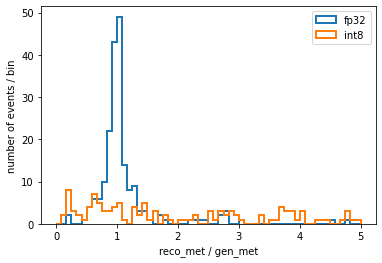

In [47]:
plt.hist(pred_met/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="fp32");
plt.hist(pred_met_int8/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="int8");
plt.xlabel("reco_met / gen_met")
plt.ylabel("number of events / bin")
plt.legend(loc="best")

In [48]:
# Defining the 3-momentum for the quantized particles.


In [49]:
px_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pz_int8 = preds_unpacked_int8["pt"] * np.sinh(preds_unpacked_int8["eta"]) * msk_true_particles
phi_int8 = np.arctan2(preds_unpacked_int8["sin_phi"], preds_unpacked_int8["cos_phi"]) * msk_true_particles

px_np_int8 = px_int8.detach().cpu().numpy()
py_np_int8 = py_int8.detach().cpu().numpy()
pz_np_int8 = pz_int8.detach().cpu().numpy()
phi_np_int8 = phi_int8.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

quantized_mom = np.sqrt(np.sum(px_np_int8, axis=1)**2 + np.sum(py_np_int8, axis=1)**2 + np.sum(pz_np_int8, axis=1)**2)
int8_E_np = np.sqrt(px_np_int8**2 + py_np_int8**2 + pz_np_int8**2)


In [50]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("int8_E Shape", int8_E_np.shape)
print("px Shape", px_np_int8.shape)
print("py Shape", py_np_int8.shape)
print("pz Shape", pz_np_int8.shape)


int8_E Shape (16, 200)
px Shape (16, 200)
py Shape (16, 200)
pz Shape (16, 200)


In [51]:

INT8_Jets_particles = []   # TODO:Change this to reco_jets
for ip in range(int8_E_np.shape[0]):
    for ix in range(int8_E_np.shape[1]):
        px_value = float(px_np_int8[ip, ix])
        py_value = float(py_np_int8[ip, ix])
        pz_value = float(pz_np_int8[ip, ix])
        E_value = float(int8_E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        INT8_Jets_particles.append(particle)


In [52]:
# INT8_Jets_particles

In [53]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(INT8_Jets_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

INT8_reco_jets = []
for future in futures:
    INT8_reco_jets.extend(future.result())


In [54]:
for i, jet in enumerate(INT8_reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.042896021468405335 0.28781828540681575 5.077070008271944 0.044685062021017075
Jet 3 : 0.05048450439488717 -2.9105019810120414 2.950329933305678 0.46497398614883423
Jet 4 : 0.2623754022198784 -4.026813416016047 0.4607782343929308 7.3595967292785645
Jet 5 : 0.30600831951709684 -4.362343938649678 5.250558280556705 12.003716468811035
Jet 6 : 0.5067151736707779 0.7875412244189958 3.5862781296310144 0.67214435338974
Jet 7 : 0.6010212862610597 -3.5409234801126344 0.22132971003957175 10.375956535339355
Jet 8 : 0.6487825550245411 -3.947957004875568 1.6607264212054387 16.819273471832275
Jet 9 : 0.6661709856550436 -3.158910005574564 1.9913328398502137 7.856617450714111
Jet 10 : 0.8367933342235239 2.581819108752742 3.542584139366838 5.563338279724121
Jet 11 : 1.1025917268919003 1.4188344006907518 3.379453132508136 2.411531925201416
Jet 12 : 1.1628402659739723 -3.3834859336681262 4.48114216899547 17.156118392944336
Jet 13 : 1.1899790561526709 -3.26315422848103

In [55]:
print("Number of Jets:", len(INT8_reco_jets))


INT8_jet_pt = [jet.pt() for jet in INT8_reco_jets]

Number of Jets: 232


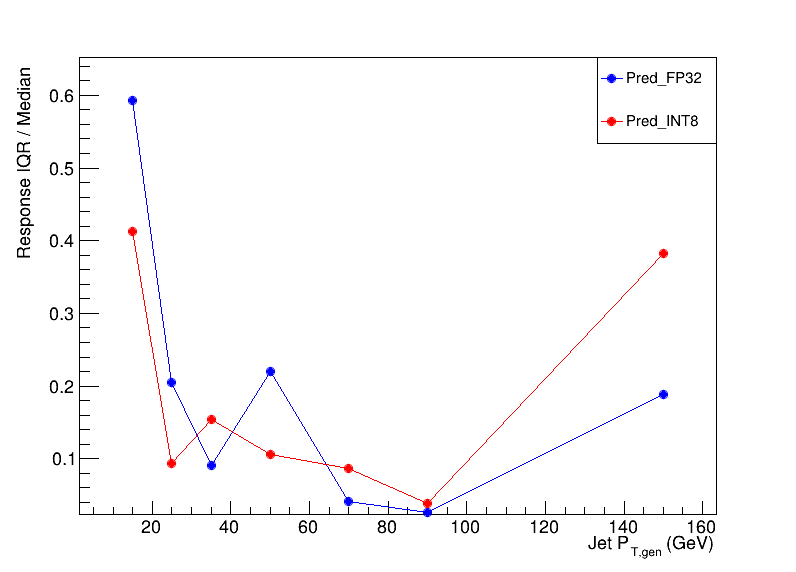

In [56]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
reco_ratio_iqr_median = []
int8_ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter gen_jet_pt values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Filter reco_jet_pt values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Filter INT8_jet_pt values within the bin
    INT8_jet_values_in_bin = [pt for pt in INT8_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any values in both gen_jet_pt and reco_jet_pt
    if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0 or len(INT8_jet_values_in_bin) == 0:
        # Append NaN values
        reco_ratio_iqr_median.append(np.nan)
        int8_ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    reco_ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    reco_ratio_iqr = np.percentile(reco_ratio_values_in_bin, 75) - np.percentile(reco_ratio_values_in_bin, 25)
    reco_ratio_median = np.median(reco_ratio_values_in_bin)
    reco_ratio_iqr_median_ratio = reco_ratio_iqr / reco_ratio_median
    reco_ratio_iqr_median.append(reco_ratio_iqr_median_ratio)

    # Calculate IQR and median for INT8_jet_pt / gen_jet_pt values
    int8_ratio_values_in_bin = [int8 / gen for int8, gen in zip(INT8_jet_values_in_bin, gen_jet_values_in_bin)]
    int8_ratio_iqr = np.percentile(int8_ratio_values_in_bin, 75) - np.percentile(int8_ratio_values_in_bin, 25)
    int8_ratio_median = np.median(int8_ratio_values_in_bin)
    int8_ratio_iqr_median_ratio = int8_ratio_iqr / int8_ratio_median
    int8_ratio_iqr_median.append(int8_ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered_reco = [x for x, y in zip(x_vals, reco_ratio_iqr_median) if not np.isnan(y)]
reco_ratio_iqr_median_filtered = [y for y in reco_ratio_iqr_median if not np.isnan(y)]

x_vals_filtered_int8 = [x for x, y in zip(x_vals, int8_ratio_iqr_median) if not np.isnan(y)]
int8_ratio_iqr_median_filtered = [y for y in int8_ratio_iqr_median if not np.isnan(y)]

# Create TGraphs with filtered values
gr_reco_ratio = ROOT.TGraph(len(x_vals_filtered_reco), np.array(x_vals_filtered_reco), np.array(reco_ratio_iqr_median_filtered))
gr_int8_ratio = ROOT.TGraph(len(x_vals_filtered_int8), np.array(x_vals_filtered_int8), np.array(int8_ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_reco_ratio.SetTitle("")
gr_int8_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the first graph (Reco_jet_pt/gen_jet_pt)
gr_reco_ratio.SetMarkerStyle(20)
gr_reco_ratio.SetMarkerColor(ROOT.kBlue)
gr_reco_ratio.SetLineColor(ROOT.kBlue)
gr_reco_ratio.GetXaxis().SetTitle("Jet P_{T,gen} (GeV)")
gr_reco_ratio.GetYaxis().SetTitle("Response IQR / Median")
gr_reco_ratio.Draw("APL")

# Draw the second graph (INT8_jet_pt/gen_jet_pt) on the same canvas
gr_int8_ratio.SetMarkerStyle(20)
gr_int8_ratio.SetMarkerColor(ROOT.kRed)
gr_int8_ratio.SetLineColor(ROOT.kRed)
gr_int8_ratio.Draw("PL same")

# Get the X and Y axes
xaxis = gr_reco_ratio.GetXaxis()
yaxis = gr_reco_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)

# Set y-axis range to show both plots
min_y = min(min(reco_ratio_iqr_median_filtered), min(int8_ratio_iqr_median_filtered))
max_y = max(max(reco_ratio_iqr_median_filtered), max(int8_ratio_iqr_median_filtered))
yaxis.SetRangeUser(min_y * 0.9, max_y * 1.1)

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_reco_ratio, "Pred_FP32", "lp")
legend.AddEntry(gr_int8_ratio, "Pred_INT8", "lp")
legend.Draw()

# Show the canvas
canvas.Draw()
